In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import CLIPTokenizer, CLIPTextModel, CLIPVisionModel
from torch.utils.data import DataLoader, Dataset
import PIL
import os
from tqdm import tqdm
import pandas as pd
import torchvision.transforms as transforms
import regex
import numpy as np
from sklearn.model_selection import train_test_split
import random
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

d:\anaconda3\envs\CS4248\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
elco_df = pd.read_csv('../../data/ELCo.csv')
device

'cpu'

In [4]:
def comp_type_map(comp_type):
    type_to_label = {'Direct': 0, 'Metaphorical': 1, 'Semantic list': 2, 'Reduplication': 3, 'Single': 4}
    return type_to_label[comp_type]

def label_to_comp_type(label):
    label_to_type = {0: 'Direct', 1: 'Metaphorical', 2: 'Semantic list', 3: 'Reduplication', 4: 'Single'}
    return label_to_type[label]

In [3]:
class EmojiCLIP(nn.Module):
    def __init__(self, vit_model=CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")):
        super().__init__()
        self.vit = vit_model

        # freeze ViT in early training
        for param in self.vit.parameters():
            param.requires_grad = False
    def extract_embedding(self, image):
        with torch.no_grad():
            return self.vit(pixel_values=image).pooler_output
    
    def forward(self, image):
        image_embedding = self.extract_embedding(image)
        return image_embedding

In [5]:
class EmojiImageDataset(Dataset):
    def __init__(self, image_dir, transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])):
        super().__init__()
        self.image_dir = image_dir
        self.images = os.listdir(image_dir)
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        image = PIL.Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, self.images[idx].removesuffix('.png')

In [6]:
emoji_image_dataset = EmojiImageDataset('../../images')
emoji_image_dataloader = DataLoader(emoji_image_dataset, batch_size=64, shuffle=False)

model = EmojiCLIP().eval().to(device)
all_embeddings = []
all_emoji_descs = []
with torch.no_grad():
    for batch_images, batch_descs in tqdm(emoji_image_dataloader, desc='Extracting embeddings'):
        batch_images = batch_images.to(device)
        batch_embeddings = model(batch_images)
        all_embeddings.append(batch_embeddings)
        all_emoji_descs.extend(batch_descs)

all_embeddings = torch.cat(all_embeddings, dim=0) # (N, 768)
emoji_embed_dict = {desc: embed for desc, embed in zip(all_emoji_descs, all_embeddings)}

Extracting embeddings: 100%|██████████| 14/14 [00:58<00:00,  4.15s/it]


In [7]:
class TypeClassifier(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=512, num_classes=5, dropout=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes),
        )
        
    def forward(self, x):
        return self.model(x)

In [8]:
class EmojisDataset(Dataset):
    def __init__(self, emoji_embed_dict, elco_df, em_max_len=3, text_max_len=6, tokenizer='openai/clip-vit-base-patch32'):
        super().__init__()
        self.elco_df = elco_df
        self.emoji_descriptions = [self.preprocess_emoji_description(desc) for desc in elco_df["Description"]]
        self.raw_emoji_descriptions = elco_df["Description"].values
        self.emoji_embed_dict = emoji_embed_dict
        self.em_max_len = em_max_len
        self.text_max_len = text_max_len
        self.clip_tokenizer = CLIPTokenizer.from_pretrained(tokenizer)
        self.composition_type = [comp_type_map(t) for t in elco_df['Composition strategy'].values]
    
    def preprocess_emoji_description(self, text):
        text = text.replace('\'\'', '').lower()
        split_text = regex.findall(r'\':?(.*?):?\'', text)
        return split_text
    def preprocess_en(self, text):
        return "This is" + text.lower().strip()
    
    def __len__(self):
        return len(self.emoji_descriptions)
    
    def __getitem__(self, index):
        emoji_descs = self.emoji_descriptions[index]
        emoji_embeds = [self.emoji_embed_dict[desc] for desc in emoji_descs]
        en_text = self.preprocess_en(self.elco_df['EN'].values[index])
        composition_type = self.composition_type[index]
        assert len(emoji_embeds) == len(emoji_descs)
        if len(emoji_embeds) < self.em_max_len:
            emoji_embeds += [torch.zeros_like(emoji_embeds[0]) for _ in range(self.em_max_len - len(emoji_embeds))]
        else:
            emoji_embeds = emoji_embeds[:self.em_max_len]
        # emoji_embeds = torch.stack(emoji_embeds, dim=0)
        emoji_embeds = torch.concatenate(emoji_embeds, dim=-1)
        
        emoji_desc = " ".join(emoji_descs)
        desc_tokens = self.clip_tokenizer(emoji_desc, 
                                  truncation=True, 
                                  padding='max_length',
                                  return_tensors='pt',
                                  max_length=64)
        
        en_tokens = self.clip_tokenizer(en_text, 
                                  truncation=True, 
                                  padding='max_length',
                                  return_tensors='pt',
                                  max_length=self.text_max_len)
        en_tokens = {k: v.squeeze(0) for k, v in en_tokens.items()}
        desc_tokens = {k: v.squeeze(0) for k, v in desc_tokens.items()}
        return (emoji_embeds, desc_tokens, en_tokens), composition_type
        

In [9]:
generator = torch.Generator()
# generator.manual_seed(42)
train_df, validate_df = train_test_split(elco_df, test_size=0.08, random_state=42)
# validate_df, test_df = train_test_split(validate_df, test_size=0.3, random_state=42)
emojis_train_dataset = EmojisDataset(emoji_embed_dict, train_df)
emojis_train_dataloader = DataLoader(emojis_train_dataset, batch_size=32, shuffle=True, drop_last=True, generator=generator)
emojis_validate_dataset = EmojisDataset(emoji_embed_dict, validate_df)
emojis_validate_dataloader = DataLoader(emojis_validate_dataset, batch_size=32, shuffle=False, drop_last=True)
# emojis_test_dataset = EmojisDataset(emoji_embed_dict, test_df)
# emojis_test_dataloader = DataLoader(emojis_test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [10]:
for em_en_pair, ctype in emojis_train_dataloader:
    print(em_en_pair[0].shape, em_en_pair[1]['input_ids'].shape)
    print(ctype[0])
    break

torch.Size([32, 2304]) torch.Size([32, 64])
tensor(0)


In [11]:
class EmojiCompositionModel(nn.Module):
    def __init__(self, text_encoder='openai/clip-vit-base-patch32',
                 image_embed_dim=768, projection_dim=512, freeze_clip=False, text_ratio=0.5, visual_ratio=0.5):
        super().__init__()


        # self.emoji_transformer = ImageEmbedTransformer(embedding_dim=image_embed_dim, num_layers=num_layers)

        self.text_encoder = CLIPTextModel.from_pretrained(text_encoder).text_model
        self.text_hidden_dim = self.text_encoder.config.hidden_size
        self.desc_embed_size = int(projection_dim * text_ratio)
        self.image_embed_size = int(projection_dim * visual_ratio)
        self.text_proj_dim = self.desc_embed_size + self.image_embed_size
        
        if freeze_clip:
            for name, param in self.text_encoder.named_parameters():
                    # if "encoder.layers.10" in name or "encoder.layers.11" in name:
                    #     param.requires_grad = True
                    # else:
                    param.requires_grad = False
                    
        
        self.text_proj = nn.Sequential(
            nn.Linear(self.text_hidden_dim, self.text_proj_dim),
            nn.ReLU(),
            nn.LayerNorm(self.text_proj_dim),
            nn.Dropout(0.1),
            )
        
        self.desc_proj = nn.Sequential(
            nn.Linear(self.text_hidden_dim, self.desc_embed_size),
            nn.ReLU(),
            nn.LayerNorm(self.desc_embed_size),
            nn.Dropout(0.1),
            )
        
        self.image_proj = nn.Sequential(
            nn.Linear(image_embed_dim, self.image_embed_size),
            nn.ReLU(),
            nn.LayerNorm(self.image_embed_size),
            nn.Dropout(0.1)
            )
        
        input_dim = self.text_proj_dim * 3
        self.classifier = TypeClassifier(input_dim=input_dim, hidden_dim=projection_dim * 2, num_classes=5)
        
    def forward(self, img_seq, desc_input, text_input):
        desc_out = self.text_encoder(**desc_input).pooler_output
        z_desc = self.desc_proj(desc_out)
        z_image = self.image_proj(img_seq)
        
        z_emoji = torch.concatenate([z_desc, z_image], dim=-1)
        
        text_out = self.text_encoder(**text_input).pooler_output
        z_text = self.text_proj(text_out)

        z_emoji = F.normalize(z_emoji, dim=-1)
        z_text = F.normalize(z_text, dim=-1)
        z_concat = torch.cat([z_emoji, z_text, torch.abs(z_emoji - z_text)], dim=-1)
        output = self.classifier(z_concat)

        return (z_emoji, z_text), output

In [15]:
class EarlyStopping:
    def __init__(self, patience=2, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, accuracy):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [16]:
def train(text_ratio, visual_ratio, verbose=False):
    # reconstruct text dataloader -> each bacth is a list of all possible en for the emojis in given batch
    labels = [data[1] for data in emojis_train_dataset]
    class_counts = Counter(labels)
    class_weights = torch.tensor([len(labels) / count for label, count in class_counts.items()])

    en_em_model = EmojiCompositionModel(image_embed_dim=2304, freeze_clip=True, text_ratio=text_ratio, visual_ratio=visual_ratio).to(device)
    optimizer = torch.optim.AdamW(en_em_model.parameters(), lr=2e-5)
    early_stopping = EarlyStopping(patience=3)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    num_epochs = 45

    for epoch in tqdm(range(num_epochs), total=num_epochs, desc=f'Training at p_text={text_ratio}'):
        total_loss = 0.0
        en_em_model.train()
        incorrect_labels = {'Direct': 0, 'Metaphorical': 0, 'Semantic list': 0, 'Reduplication': 0, 'Single': 0}
        correct_count_train = 0
        
        for (emoji_embeds, desc_input, en_input), ctype in emojis_train_dataloader:
            (z_emojis, z_text), output = en_em_model(emoji_embeds, desc_input, en_input)
            
            classifier_loss = F.cross_entropy(output, ctype, weight=class_weights, reduction='none')
            
            classifier_pred = torch.argmax(output, dim=-1)
            correct_count_train += torch.sum(classifier_pred == ctype).item()
            # for i, pred in enumerate(clssifier_pred):
            #     if pred != ctype[i]:
            #         incorrect_labels[label_to_comp_type(ctype[i].item())] += 1
            
            
            target_class = torch.tensor([0, 1])
            is_target_class = torch.isin(ctype, target_class)
            is_incorrect = (classifier_pred != ctype)
            should_double = is_target_class & is_incorrect
            # print(classifier_loss,"classifier_loss")
            weights = torch.ones_like(classifier_loss)
            weights[should_double] = 2
            adjusted_loss = classifier_loss * weights
            classifier_loss = adjusted_loss.mean()
                    
            match_labels = torch.arange(emojis_train_dataloader.batch_size).to(device)
            loss_per_emojis = z_emojis @ z_text.T
            loss_per_text = loss_per_emojis.T
            loss_em = F.cross_entropy(loss_per_emojis, match_labels)
            loss_text = F.cross_entropy(loss_per_text, match_labels)

            loss = classifier_loss + (loss_em + loss_text) / 2
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        total_loss /= len(emojis_train_dataloader)
        train_accuracy = correct_count_train / len(emojis_train_dataset)
            
        en_em_model.eval()
        correct_count = 0
        precision_scores = []
        recall_scores = []
        f1_scores = []
        with torch.no_grad():
            for (emoji_embeds, desc_input, en_input), ctype in emojis_validate_dataloader:
                _, output = en_em_model(emoji_embeds, desc_input, en_input)
                prediction = torch.argmax(output, dim=-1)
                correct_count += torch.sum(prediction == ctype).item()
                precision_scores.append(precision_score(ctype.cpu(), prediction.cpu(), average='macro', zero_division=0))
                recall_scores.append(recall_score(ctype.cpu(), prediction.cpu(), average='macro', zero_division=0))
                f1_scores.append(f1_score(ctype.cpu(), prediction.cpu(), average='macro', zero_division=0))
                for i, pred in enumerate(prediction):
                    # print(f"Pred: {pred}, True: {ctype[i]}")
                    if pred != ctype[i]:
                        incorrect_labels[label_to_comp_type(ctype[i].item())] += 1
            validation_accuracy = correct_count / len(emojis_validate_dataset)
            precision = np.mean(precision_scores)
            recall = np.mean(recall_scores)
            f1 = np.mean(f1_scores)
            
        if verbose:    
            print(f'Incorrect labels: {incorrect_labels}')
            print(f'Epoch {epoch} - Train Loss: {total_loss}, Train accuracy: {train_accuracy}')
            print(f'Validation Accuracy: {validation_accuracy}, recall: {recall}, precision: {precision}, f1: {f1}')
            print("=============================")
        
        early_stopping(total_loss, validation_accuracy)
        if early_stopping.early_stop:
            if verbose:
                print(f'Early stopping at epoch {epoch}')
            break
    return {
        "train_accuracy": train_accuracy,
        "validation_accuracy": validation_accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "incorrect_labels": incorrect_labels,
    }

In [25]:
import winsound

In [ ]:
text_ratios = [0.2, 0.4, 0.6, 0.8, 1.0]
visual_ratios = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

# text_ratio = [0.5]
# visual_ratio = [0.5]
results = []
try:
    for text_ratio in text_ratios:
        for visual_ratio in visual_ratios:
            print(f"Training with p_text: {text_ratio}, p_visual: {visual_ratio}")
            result = train(text_ratio, visual_ratio)
            print(f"Results for p_text {text_ratio}:", result)
            results.append(result)
            print("==========================================")
except Exception as e:
    print(f"An error occurred: {e}")
    winsound.Beep(1000, 1000)

Training with p_text: 0.2, p_visual: 0


d:\anaconda3\envs\CS4248\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
Training at p_text=0.2: 100%|██████████| 45/45 [27:52<00:00, 37.16s/it]


Results for p_text 0.2: {'train_accuracy': 0.771353482260184, 'validation_accuracy': 0.5939849624060151, 'recall': 0.667257326007326, 'precision': 0.6632824283559577, 'f1': 0.6431044259616224, 'incorrect_labels': {'Direct': 14, 'Metaphorical': 29, 'Semantic list': 2, 'Reduplication': 2, 'Single': 2}}
Training with p_text: 0.2, p_visual: 0.2


Training at p_text=0.2: 100%|██████████| 45/45 [28:05<00:00, 37.45s/it]


Results for p_text 0.2: {'train_accuracy': 0.9454664914586071, 'validation_accuracy': 0.6691729323308271, 'recall': 0.730128205128205, 'precision': 0.7075126262626262, 'f1': 0.7069018922612892, 'incorrect_labels': {'Direct': 13, 'Metaphorical': 22, 'Semantic list': 2, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 0.2, p_visual: 0.4


Training at p_text=0.2: 100%|██████████| 45/45 [28:24<00:00, 37.87s/it]


Results for p_text 0.2: {'train_accuracy': 0.9763469119579501, 'validation_accuracy': 0.6390977443609023, 'recall': 0.5937026862026862, 'precision': 0.6086433664374842, 'f1': 0.590067716141929, 'incorrect_labels': {'Direct': 15, 'Metaphorical': 21, 'Semantic list': 4, 'Reduplication': 3, 'Single': 0}}
Training with p_text: 0.2, p_visual: 0.6


Training at p_text=0.2: 100%|██████████| 45/45 [28:04<00:00, 37.44s/it]


Results for p_text 0.2: {'train_accuracy': 0.9842312746386334, 'validation_accuracy': 0.6691729323308271, 'recall': 0.6650091575091575, 'precision': 0.7029095047109752, 'f1': 0.6582917949278398, 'incorrect_labels': {'Direct': 13, 'Metaphorical': 20, 'Semantic list': 4, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 0.2, p_visual: 0.8


Training at p_text=0.2: 100%|██████████| 45/45 [28:05<00:00, 37.46s/it]


Results for p_text 0.2: {'train_accuracy': 0.9848883048620236, 'validation_accuracy': 0.6541353383458647, 'recall': 0.6129456654456655, 'precision': 0.6230656108597284, 'f1': 0.5999783764622475, 'incorrect_labels': {'Direct': 16, 'Metaphorical': 18, 'Semantic list': 5, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 0.2, p_visual: 1.0


Training at p_text=0.2: 100%|██████████| 45/45 [27:57<00:00, 37.27s/it]


Results for p_text 0.2: {'train_accuracy': 0.9848883048620236, 'validation_accuracy': 0.6390977443609023, 'recall': 0.5832600732600733, 'precision': 0.6340853554340397, 'f1': 0.5869251645544749, 'incorrect_labels': {'Direct': 17, 'Metaphorical': 18, 'Semantic list': 5, 'Reduplication': 3, 'Single': 0}}
Training with p_text: 0.4, p_visual: 0


d:\anaconda3\envs\CS4248\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
Training at p_text=0.4: 100%|██████████| 45/45 [28:00<00:00, 37.34s/it]


Results for p_text 0.4: {'train_accuracy': 0.8219448094612353, 'validation_accuracy': 0.5789473684210527, 'recall': 0.6091681929181929, 'precision': 0.6101975108225108, 'f1': 0.5939768220285462, 'incorrect_labels': {'Direct': 18, 'Metaphorical': 26, 'Semantic list': 3, 'Reduplication': 2, 'Single': 2}}
Training with p_text: 0.4, p_visual: 0.2


Training at p_text=0.4: 100%|██████████| 45/45 [27:49<00:00, 37.10s/it]


Results for p_text 0.4: {'train_accuracy': 0.9559789750328516, 'validation_accuracy': 0.6390977443609023, 'recall': 0.7485233516483516, 'precision': 0.71751998001998, 'f1': 0.7158805777555777, 'incorrect_labels': {'Direct': 18, 'Metaphorical': 21, 'Semantic list': 2, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 0.4, p_visual: 0.4


Training at p_text=0.4: 100%|██████████| 45/45 [28:04<00:00, 37.44s/it]


Results for p_text 0.4: {'train_accuracy': 0.9802890932982917, 'validation_accuracy': 0.6466165413533834, 'recall': 0.5964010989010989, 'precision': 0.6155681818181817, 'f1': 0.597592005695454, 'incorrect_labels': {'Direct': 16, 'Metaphorical': 19, 'Semantic list': 4, 'Reduplication': 3, 'Single': 0}}
Training with p_text: 0.4, p_visual: 0.6


Training at p_text=0.4: 100%|██████████| 45/45 [28:16<00:00, 37.70s/it]


Results for p_text 0.4: {'train_accuracy': 0.985545335085414, 'validation_accuracy': 0.6616541353383458, 'recall': 0.6600671550671551, 'precision': 0.6679060033104149, 'f1': 0.6587733243767726, 'incorrect_labels': {'Direct': 15, 'Metaphorical': 19, 'Semantic list': 4, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 0.4, p_visual: 0.8


Training at p_text=0.4: 100%|██████████| 45/45 [27:15<00:00, 36.35s/it]


Results for p_text 0.4: {'train_accuracy': 0.9862023653088042, 'validation_accuracy': 0.6466165413533834, 'recall': 0.6094108669108669, 'precision': 0.6370090289827132, 'f1': 0.6039002661687589, 'incorrect_labels': {'Direct': 15, 'Metaphorical': 20, 'Semantic list': 5, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 0.4, p_visual: 1.0


Training at p_text=0.4: 100%|██████████| 45/45 [25:32<00:00, 34.06s/it]


Results for p_text 0.4: {'train_accuracy': 0.9842312746386334, 'validation_accuracy': 0.6541353383458647, 'recall': 0.5985378510378511, 'precision': 0.6170218633705475, 'f1': 0.5981947373729608, 'incorrect_labels': {'Direct': 18, 'Metaphorical': 16, 'Semantic list': 4, 'Reduplication': 3, 'Single': 0}}
Training with p_text: 0.6, p_visual: 0


d:\anaconda3\envs\CS4248\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
Training at p_text=0.6: 100%|██████████| 45/45 [25:21<00:00, 33.81s/it]


Results for p_text 0.6: {'train_accuracy': 0.8442838370565046, 'validation_accuracy': 0.5639097744360902, 'recall': 0.6567246642246642, 'precision': 0.6596687136393018, 'f1': 0.6382551389140595, 'incorrect_labels': {'Direct': 17, 'Metaphorical': 30, 'Semantic list': 2, 'Reduplication': 1, 'Single': 3}}
Training with p_text: 0.6, p_visual: 0.2


Training at p_text=0.6: 100%|██████████| 45/45 [25:28<00:00, 33.97s/it]


Results for p_text 0.6: {'train_accuracy': 0.954664914586071, 'validation_accuracy': 0.6691729323308271, 'recall': 0.6860057997557998, 'precision': 0.6986737567987567, 'f1': 0.6878996566368484, 'incorrect_labels': {'Direct': 17, 'Metaphorical': 17, 'Semantic list': 3, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 0.6, p_visual: 0.4


Training at p_text=0.6: 100%|██████████| 45/45 [25:47<00:00, 34.40s/it]


Results for p_text 0.6: {'train_accuracy': 0.9796320630749015, 'validation_accuracy': 0.6390977443609023, 'recall': 0.652184065934066, 'precision': 0.6728222696421226, 'f1': 0.647920380469106, 'incorrect_labels': {'Direct': 15, 'Metaphorical': 22, 'Semantic list': 4, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 0.6, p_visual: 0.6


Training at p_text=0.6: 100%|██████████| 45/45 [25:24<00:00, 33.87s/it]


Results for p_text 0.6: {'train_accuracy': 0.9848883048620236, 'validation_accuracy': 0.6390977443609023, 'recall': 0.6269322344322344, 'precision': 0.6446608946608947, 'f1': 0.6218675037481259, 'incorrect_labels': {'Direct': 17, 'Metaphorical': 19, 'Semantic list': 4, 'Reduplication': 3, 'Single': 0}}
Training with p_text: 0.6, p_visual: 0.8


Training at p_text=0.6: 100%|██████████| 45/45 [26:05<00:00, 34.79s/it] 


Results for p_text 0.6: {'train_accuracy': 0.980946123521682, 'validation_accuracy': 0.6390977443609023, 'recall': 0.5905250305250305, 'precision': 0.6351875901875902, 'f1': 0.6007523955466114, 'incorrect_labels': {'Direct': 18, 'Metaphorical': 18, 'Semantic list': 4, 'Reduplication': 3, 'Single': 0}}
Training with p_text: 0.6, p_visual: 1.0


Training at p_text=0.6: 100%|██████████| 45/45 [24:58<00:00, 33.31s/it]


Results for p_text 0.6: {'train_accuracy': 0.985545335085414, 'validation_accuracy': 0.6541353383458647, 'recall': 0.6805662393162393, 'precision': 0.7267319960741012, 'f1': 0.6896683651996152, 'incorrect_labels': {'Direct': 18, 'Metaphorical': 17, 'Semantic list': 3, 'Reduplication': 3, 'Single': 0}}
Training with p_text: 0.8, p_visual: 0


d:\anaconda3\envs\CS4248\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
Training at p_text=0.8: 100%|██████████| 45/45 [24:38<00:00, 32.86s/it]


Results for p_text 0.8: {'train_accuracy': 0.8620236530880421, 'validation_accuracy': 0.6240601503759399, 'recall': 0.6393162393162393, 'precision': 0.6674075924075924, 'f1': 0.6426307353235825, 'incorrect_labels': {'Direct': 16, 'Metaphorical': 22, 'Semantic list': 3, 'Reduplication': 1, 'Single': 3}}
Training with p_text: 0.8, p_visual: 0.2


Training at p_text=0.8: 100%|██████████| 45/45 [24:44<00:00, 32.99s/it]


Results for p_text 0.8: {'train_accuracy': 0.973718791064389, 'validation_accuracy': 0.6541353383458647, 'recall': 0.6805601343101344, 'precision': 0.6879843196019666, 'f1': 0.6707386132386133, 'incorrect_labels': {'Direct': 17, 'Metaphorical': 19, 'Semantic list': 3, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 0.8, p_visual: 0.4


Training at p_text=0.8: 100%|██████████| 45/45 [24:49<00:00, 33.09s/it]


Results for p_text 0.8: {'train_accuracy': 0.9763469119579501, 'validation_accuracy': 0.6541353383458647, 'recall': 0.6788507326007327, 'precision': 0.6692836452762922, 'f1': 0.66412853566002, 'incorrect_labels': {'Direct': 17, 'Metaphorical': 19, 'Semantic list': 3, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 0.8, p_visual: 0.6


Training at p_text=0.8: 100%|██████████| 45/45 [25:48<00:00, 34.41s/it]


Results for p_text 0.8: {'train_accuracy': 0.980946123521682, 'validation_accuracy': 0.6390977443609023, 'recall': 0.648956043956044, 'precision': 0.6639883604957135, 'f1': 0.6399022363818091, 'incorrect_labels': {'Direct': 17, 'Metaphorical': 20, 'Semantic list': 3, 'Reduplication': 3, 'Single': 0}}
Training with p_text: 0.8, p_visual: 0.8


Training at p_text=0.8: 100%|██████████| 45/45 [27:43<00:00, 36.97s/it]


Results for p_text 0.8: {'train_accuracy': 0.985545335085414, 'validation_accuracy': 0.6766917293233082, 'recall': 0.6677457264957265, 'precision': 0.6591532976827095, 'f1': 0.6562386872386873, 'incorrect_labels': {'Direct': 17, 'Metaphorical': 15, 'Semantic list': 4, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 0.8, p_visual: 1.0


Training at p_text=0.8: 100%|██████████| 45/45 [32:57<00:00, 43.94s/it]


Results for p_text 0.8: {'train_accuracy': 0.9868593955321945, 'validation_accuracy': 0.6616541353383458, 'recall': 0.6230250305250306, 'precision': 0.6370940170940171, 'f1': 0.6212915019332677, 'incorrect_labels': {'Direct': 17, 'Metaphorical': 17, 'Semantic list': 4, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 1.0, p_visual: 0


d:\anaconda3\envs\CS4248\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
Training at p_text=1.0: 100%|██████████| 45/45 [29:01<00:00, 38.70s/it]


Results for p_text 1.0: {'train_accuracy': 0.866622864651774, 'validation_accuracy': 0.5714285714285714, 'recall': 0.5926007326007325, 'precision': 0.6037174100409394, 'f1': 0.591688808373591, 'incorrect_labels': {'Direct': 17, 'Metaphorical': 27, 'Semantic list': 3, 'Reduplication': 2, 'Single': 3}}
Training with p_text: 1.0, p_visual: 0.2


Training at p_text=1.0: 100%|██████████| 45/45 [27:31<00:00, 36.70s/it]


Results for p_text 1.0: {'train_accuracy': 0.961892247043364, 'validation_accuracy': 0.6541353383458647, 'recall': 0.676376678876679, 'precision': 0.6937805944055944, 'f1': 0.6747245723968973, 'incorrect_labels': {'Direct': 19, 'Metaphorical': 17, 'Semantic list': 3, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 1.0, p_visual: 0.4


Training at p_text=1.0: 100%|██████████| 45/45 [27:55<00:00, 37.23s/it]


Results for p_text 1.0: {'train_accuracy': 0.980946123521682, 'validation_accuracy': 0.6541353383458647, 'recall': 0.6961553724053724, 'precision': 0.6814046717171718, 'f1': 0.6815792316052365, 'incorrect_labels': {'Direct': 17, 'Metaphorical': 20, 'Semantic list': 3, 'Reduplication': 1, 'Single': 0}}
Training with p_text: 1.0, p_visual: 0.6


Training at p_text=1.0: 100%|██████████| 45/45 [28:15<00:00, 37.69s/it]


Results for p_text 1.0: {'train_accuracy': 0.9842312746386334, 'validation_accuracy': 0.6616541353383458, 'recall': 0.6613110500610501, 'precision': 0.6575263278388277, 'f1': 0.6531224020232641, 'incorrect_labels': {'Direct': 15, 'Metaphorical': 19, 'Semantic list': 4, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 1.0, p_visual: 0.8


Training at p_text=1.0: 100%|██████████| 45/45 [35:17<00:00, 47.05s/it]


Results for p_text 1.0: {'train_accuracy': 0.9848883048620236, 'validation_accuracy': 0.6616541353383458, 'recall': 0.6263156288156289, 'precision': 0.6405266302325126, 'f1': 0.6216642019413758, 'incorrect_labels': {'Direct': 15, 'Metaphorical': 19, 'Semantic list': 4, 'Reduplication': 2, 'Single': 0}}
Training with p_text: 1.0, p_visual: 1.0


Training at p_text=1.0: 100%|██████████| 45/45 [31:42<00:00, 42.28s/it]

Results for p_text 1.0: {'train_accuracy': 0.9829172141918529, 'validation_accuracy': 0.6466165413533834, 'recall': 0.6519948107448108, 'precision': 0.6632121825542878, 'f1': 0.6455942911255411, 'incorrect_labels': {'Direct': 18, 'Metaphorical': 18, 'Semantic list': 4, 'Reduplication': 2, 'Single': 0}}


In [29]:
text_ratio_0 = [i for i in results]

In [66]:
train_accs = [i['train_accuracy'] for i in text_ratio_0]
for r in results:
    train_accs.append(r['train_accuracy'])

validation_accs = [i['validation_accuracy'] for i in text_ratio_0]
for r in results:
    validation_accs.append(r['validation_accuracy'])
    
recalls = [i['recall'] for i in text_ratio_0]
for r in results:
    recalls.append(r['recall'])

precision_scores = [i['precision'] for i in text_ratio_0]
for r in results:
    precision_scores.append(r['precision'])

f1_scores = [i['f1'] for i in text_ratio_0]
for r in results:
    f1_scores.append(r['f1'])
    

[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]


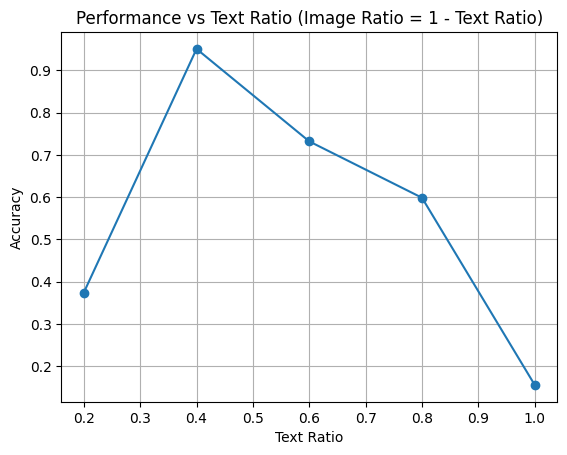

In [40]:
import matplotlib.pyplot as plt

accuracies = np.random.rand(len(text_ratios))
print(accuracies)
plt.plot(text_ratios, accuracies, marker='o')
plt.xlabel('Text Ratio')
plt.ylabel('Accuracy')
plt.title('Performance vs Text Ratio (Image Ratio = 1 - Text Ratio)')
plt.grid(True)
plt.show()


(11,) (11,) (11,)


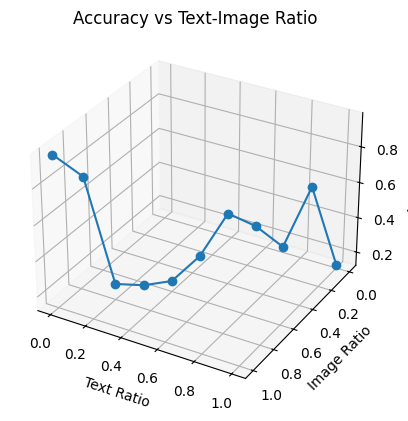

In [ ]:
image_ratios = np.array([1 - t for t in text_ratio])
print(image_ratios.shape, np.array(accuracies).shape, np.array(text_ratio).shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(text_ratio, image_ratios, accuracies, marker='o')
ax.set_xlabel('Text Ratio')
ax.set_ylabel('Image Ratio')
ax.set_zlabel('Accuracy')
plt.title('Accuracy vs Text-Image Ratio')
ax.invert_yaxis()
plt.show()

In [56]:
def plot_3d_surface(z_vals, title):
    x_vals = np.linspace(0.0, 1.0, 6)
    y_vals = np.linspace(0.0, 1.0, 6)
    xx, yy = np.meshgrid(x_vals, y_vals)
    x = xx.ravel()
    y = yy.ravel()
    z_vals = np.array(z_vals).reshape(xx.shape)
    norm = plt.Normalize(z_vals.min(), z_vals.max())
    colors = plt.cm.viridis(norm(z_vals))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    z_base = np.zeros_like(z_vals)
    dx = dy = 0.1

    surf = ax.plot_surface(xx, yy, z_vals, facecolors=colors, cmap='viridis', alpha=0.95)
    mappable = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    mappable.set_array(z_vals)
    fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)

    ax.set_xlabel('Text Ratio')
    ax.set_ylabel('Image Ratio')
    ax.set_zlabel('Accuracy')
    ax.invert_yaxis()

    ax.set_ylim(1.0, 0.0)

    plt.title(f'3D Bar Plot of {title} by Text-Image Ratio')
    plt.show()


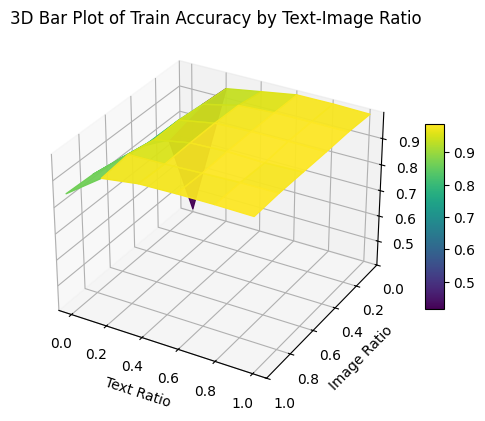

In [60]:
plot_3d_surface(train_accs, 'Train Accuracy')

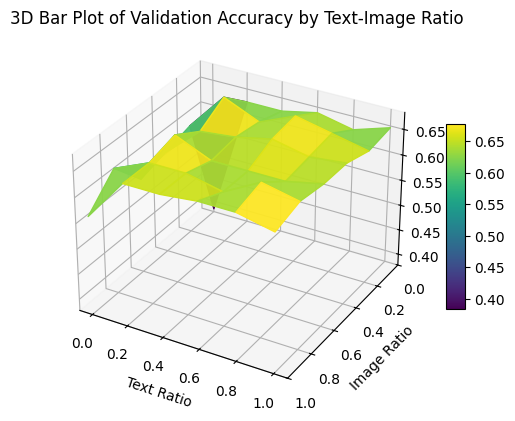

In [62]:
plot_3d_surface(validation_accs, 'Validation Accuracy')

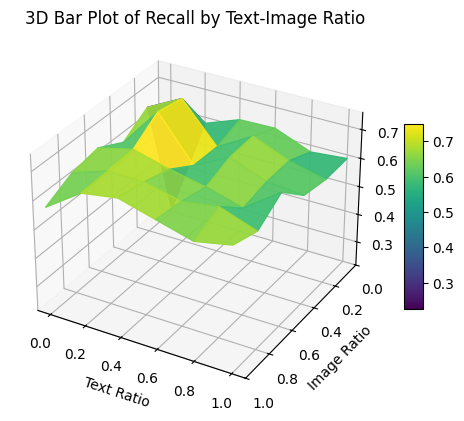

In [64]:
plot_3d_surface(recalls, 'Recall')

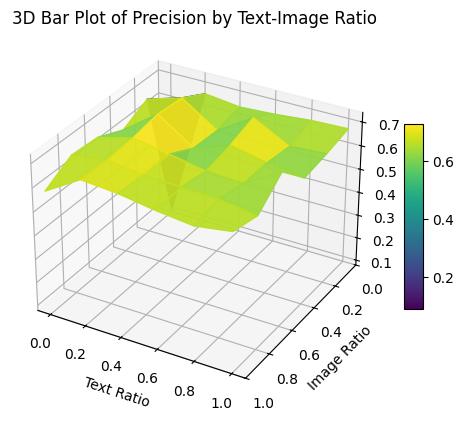

In [67]:
plot_3d_surface(precision_scores, 'Precision')

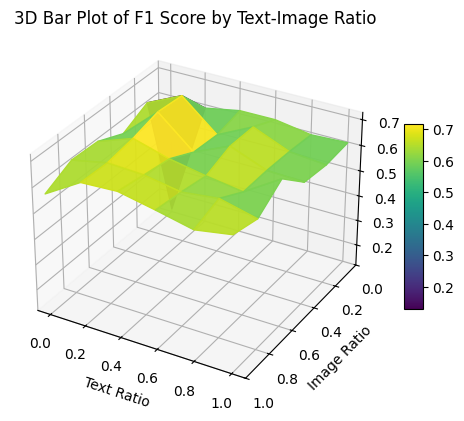

In [68]:
plot_3d_surface(f1_scores, 'F1 Score')

In [70]:
saved_results = [r for r in text_ratio_0]
for r in results:
    saved_results.append(r)
print(len(saved_results))
torch.save(saved_results, 'saved_results.pt')

36
